### Project: Credit Card Fraud Detection

-----------------------------------------------------

The dataset used in this project is publicly available on Kaggle at https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Explatory Data Analysis

In [2]:
df = pd.read_csv('credit_card.csv')

In [3]:
df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


The columns V1 ... are the results of a PCA transformation from raw dataset. This is done to maintain confidentiality and adhering to data protection regulations. The only features not transformed are 'Time' and 'Amount'.

The label of this dataset is the column 'Class', whereby 1 indicates a fraud transaction, and 0 otherwise

In [5]:
df.shape

(284807, 31)

In [7]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

<Axes: xlabel='Class', ylabel='count'>

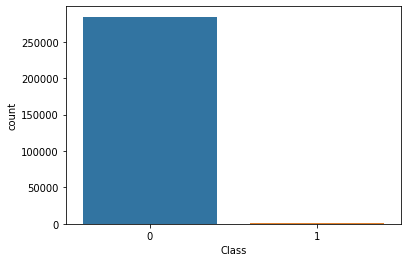

In [9]:
sns.countplot(data=df,x='Class', )

In [16]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

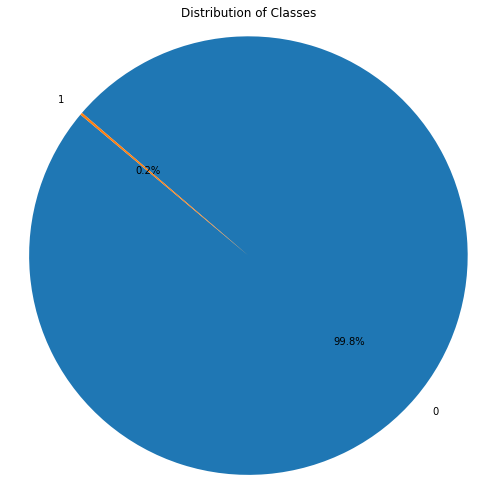

In [19]:
# Count the occurrences of each category
status_counts = df.Class.value_counts()

# Create the pie chart
plt.figure(figsize=(7, 7))
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', startangle=140)

plt.title('Distribution of Classes')
plt.axis('equal')

# Display the chart
plt.tight_layout()
plt.show()

This dataset is highly imbalanced, with the fraud cases being only about 0.2% of the whole data.

---

### Feature Transformation: Log Transformation

In [25]:
features = df.columns[:-1]
df_transformed = df.copy()

# Function to handle log transformation for skewed data
def log_transform_skewed(column):
    # For positive and zero values (log1p avoids log(0) errors)
    transformed = np.where(column >= 0, np.log1p(column), -np.log1p(-column))
    return transformed

# Compute skewness before transformation
skewness_before = df.skew()

# Apply transformation to skewed columns
for col in features:
    if abs(df[col].skew()) > 0.75:  # Threshold for skewness
        df_transformed[col] = log_transform_skewed(df[col])

C:\Users\adiba\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\adiba\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


#### Scaling & Standardizing Transformed Data

In [27]:
from sklearn.preprocessing import StandardScaler

In [28]:
X = df_transformed[features]
y = df_transformed.Class

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In this project, 3 models are being compared to identify best performing model for this specific use cases.
These models will be evaluated via their performance metrics

---

In [36]:
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.cluster import DBSCAN

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, ConfusionMatrixDisplay

## Isolation Forest
---

In [40]:
iso_forest = IsolationForest(contamination=0.05, random_state=42)
iso_preds = iso_forest.fit_predict(X_scaled)
iso_preds = [1 if x == -1 else 0 for x in iso_preds]

In [41]:
print(classification_report(y, iso_preds))
roc_auc = roc_auc_score(y, iso_preds)
print("ROC AUC Score: ", roc_auc)

              precision    recall  f1-score   support

           0       1.00      0.95      0.97    284315
           1       0.03      0.85      0.06       492

    accuracy                           0.95    284807
   macro avg       0.51      0.90      0.52    284807
weighted avg       1.00      0.95      0.97    284807

ROC AUC Score:  0.9025234806979375


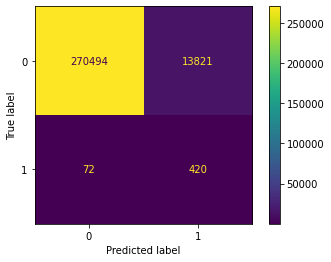

In [42]:
disp = ConfusionMatrixDisplay(confusion_matrix(y,iso_preds))
disp.plot()

## OneClass SVM
---

In [43]:
oc_svm = OneClassSVM(kernel='rbf', gamma=0.001, nu=0.05)
svm_preds = oc_svm.fit_predict(X_scaled)
svm_preds = [1 if x == -1 else 0 for x in svm_preds]

In [44]:
print(classification_report(y, svm_preds))
roc_auc = roc_auc_score(y, svm_preds)
print("ROC AUC Score: ", roc_auc)

              precision    recall  f1-score   support

           0       1.00      0.95      0.97    284315
           1       0.03      0.86      0.06       492

    accuracy                           0.95    284807
   macro avg       0.51      0.90      0.52    284807
weighted avg       1.00      0.95      0.97    284807

ROC AUC Score:  0.9035432580861518


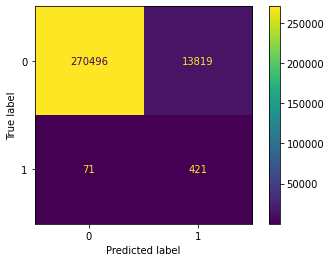

In [45]:
disp = ConfusionMatrixDisplay(confusion_matrix(y,svm_preds))
disp.plot()

## DBSCAN
---

In [48]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_preds = dbscan.fit_predict(X_scaled)
dbscan_preds = [1 if x == -1 else 0 for x in dbscan_preds]

In [49]:
print(classification_report(y, dbscan_preds))
roc_auc = roc_auc_score(y, dbscan_preds)
print("ROC AUC Score: ", roc_auc)

              precision    recall  f1-score   support

           0       1.00      0.17      0.28    284315
           1       0.00      0.97      0.00       492

    accuracy                           0.17    284807
   macro avg       0.50      0.57      0.14    284807
weighted avg       1.00      0.17      0.28    284807

ROC AUC Score:  0.568390228746914


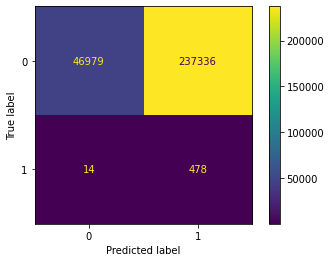

In [50]:
disp = ConfusionMatrixDisplay(confusion_matrix(y,dbscan_preds))
disp.plot()

## Conclusion

Isolation Forest and OneClass SVM models performed similarly, with 90% recall score. This shows that both models are capable of detecting anomalies from the features.

Meanwhile, DBSCAN performed poorly with a large number of false positives. In this particular use case, it is not desirable as it will raise false alarm for both bank personnels and users. 

It is worth mentioning that these models could further be fine-tuned to performed better. Other advanced models like autoencoders can also be employed for fraud transactions detection.